In [4]:

#Libraries------------------ 
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import gc
from tqdm.notebook import trange, tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import glob
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (BatchNormalization, Conv2DTranspose, 
                                     SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense)
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, MaxPool2D,Conv2DTranspose, concatenate,Input
from tensorflow.keras.callbacks import CSVLogger
K.clear_session()
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
get_ipython().run_line_magic('matplotlib', 'inline')



In [5]:
#Load image data-------------------
w,h,ch=256,256,3
def load_img(path):
    img= cv2.imread(path)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(w,h))
    return img



In [6]:
#Load data---------------------
BASE_DIR="RIWA/train/"
img_path= os.listdir(BASE_DIR+'images')
mask_path= os.listdir(BASE_DIR+'masks')



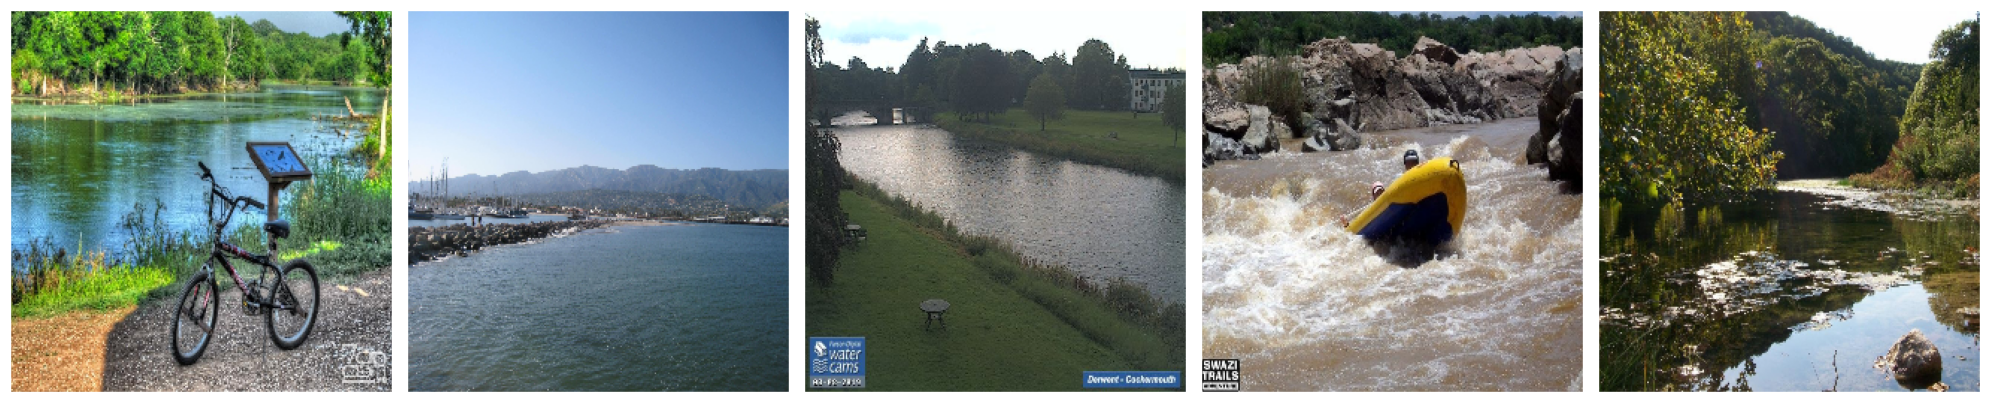

In [7]:
#plot sample images--------------
fig, ax= plt.subplots(1,5, figsize=(20, 10))
for i in range(5):
    path= BASE_DIR + 'images/'
    ax[i].imshow(load_img(path + img_path[i]))
    ax[i].set_xticks([]); ax[i].set_yticks([])

fig.tight_layout()
plt.show()




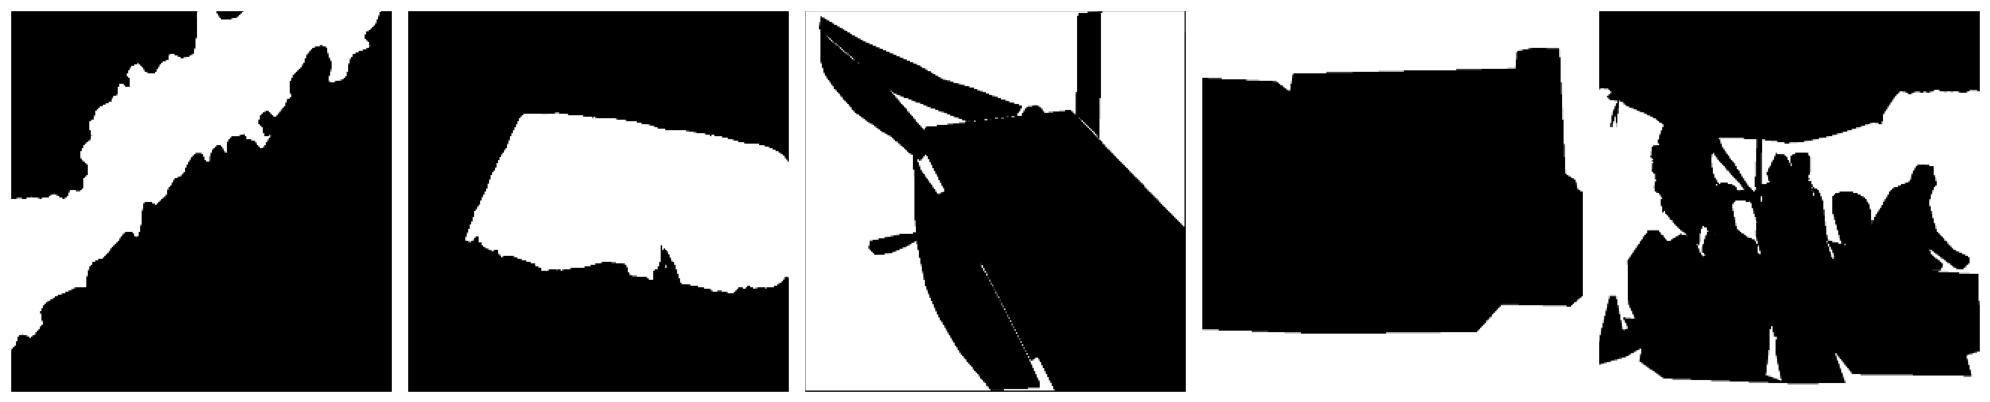

In [8]:
#plot sample masks--------------
fig, ax= plt.subplots(1,5, figsize=(20, 10))
for i in range(5):
    path= BASE_DIR + 'masks/'
    ax[i].imshow(load_img(path + mask_path[i])[:, :, 0], 'gray')
    ax[i].set_xticks([]); ax[i].set_yticks([])

fig.tight_layout()
plt.show()


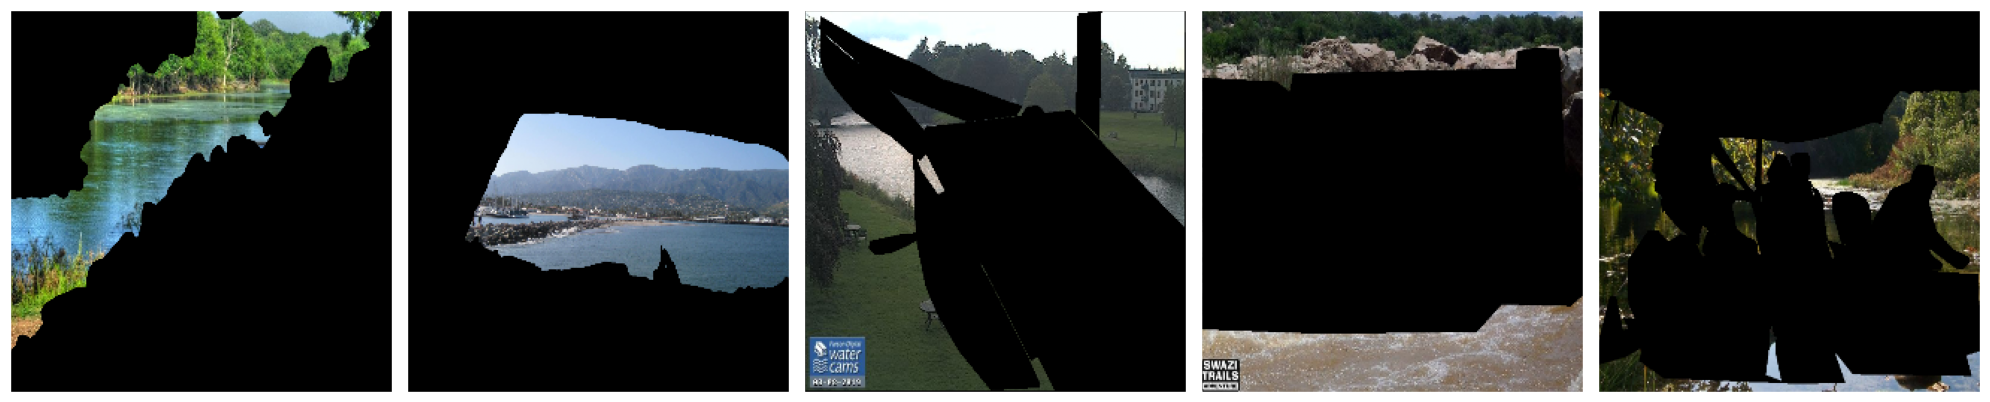

In [9]:
#plot sample images--with blended mask ------------
fig, ax= plt.subplots(1,5, figsize=(20, 10))
for i in range(5):
    path1= BASE_DIR + 'images/'
    ax[i].imshow((load_img(path1 + img_path[i])/255) * (load_img(path + mask_path[i])/255))
    ax[i].set_xticks([]); ax[i].set_yticks([])

fig.tight_layout()
plt.show()


In [10]:

#data  preparation
X_train, X_test, y_train, y_test = train_test_split(img_path, mask_path, test_size=0.2, random_state=22)
len(X_train), len(X_test)


(913, 229)

In [11]:

#batch generation-----------------------
def load_data(path_list, gray=False):
    data=[]
    for path in tqdm(path_list):
        img= load_img(path)
        if gray:
            img= img[:, :, 0:1]
        img= cv2.resize(img, (w, h))
        data.append(img)
    return np.array(data)


In [12]:
#train data generation---------------------
X_train= load_data([BASE_DIR + 'images/' + x for x in X_train])/255.0
X_test= load_data([BASE_DIR + 'images/' + x for x in X_test])/255.0

X_train.shape, X_test.shape

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

((913, 256, 256, 3), (229, 256, 256, 3))

In [13]:

##test data generation---------------------
Y_train= load_data([BASE_DIR + 'masks/' + x for x in y_train], gray=True)/255.0
Y_test= load_data([BASE_DIR + 'masks/' + x for x in y_test], gray=True)/255.0
Y_train= Y_train.reshape(-1, w, h, 1)
Y_test= Y_test.reshape(-1, w, h, 1)

Y_train.shape, Y_test.shape

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

((913, 256, 256, 1), (229, 256, 256, 1))

In [14]:
# Convolutional blocks-----------------

def conv_block(inputs,n_filters,max_pool=True):
    
    x = Conv2D(n_filters,3,padding='same',kernel_initializer='he_normal',use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(n_filters,3,padding='same',kernel_initializer='he_normal',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    skip = x
    
    if max_pool:
        next_layer = MaxPool2D()(x)
    else:
        next_layer = x
    return next_layer, skip

In [15]:
# upsampling block 
def up_block(reg_inputs,skip_inputs,n_filters):
    
    x = Conv2DTranspose(n_filters,3,2,padding='same')(reg_inputs)
    x = concatenate([x,skip_inputs],axis=3)
    x = conv_block(x,n_filters,max_pool=False)[0]
    
    return x


In [16]:
# Unet model---------------------

def unet(input_size=(h,w,ch),number_of_classes=1):
    inputs = Input(shape=input_size)
    cb1 = conv_block(inputs,32)
    cb2 = conv_block(cb1[0],64)
    cb3 = conv_block(cb2[0],128)
    cb4 = conv_block(cb3[0],256)
    cb5 = conv_block(cb4[0],512,max_pool=False)
    
    up1 = up_block(cb5[0],cb4[1],256)
    up2 = up_block(up1,cb3[1],128)
    up3 = up_block(up2,cb2[1],64)
    up4 = up_block(up3,cb1[1],32)
    
    conv1 = Conv2D(32,3,padding='same',kernel_initializer='he_normal',use_bias=False)(up4)
    bn = BatchNormalization()(conv1)
    lrl = LeakyReLU(0.2)(bn)
    outputs = Conv2D(number_of_classes,1,padding='same',activation='sigmoid')(lrl)
    
    unet = Model(inputs=inputs,outputs=outputs)
    return unet



In [17]:
# IoU loss-------------

def jaccard_coef(y_true,y_pred,smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f*y_pred_f)
    return (intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)-intersection+smooth)

# Jaccard loss-----------------
def jaccard_loss(y_true,y_pred,smooth=1):

    return -jaccard_coef(y_true,y_pred,smooth)



In [18]:
# Defining our model----------------
model = unet()


2023-03-06 17:29:16.171284: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-06 17:29:16.171320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (picox): /proc/driver/nvidia/version does not exist
2023-03-06 17:29:16.171782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


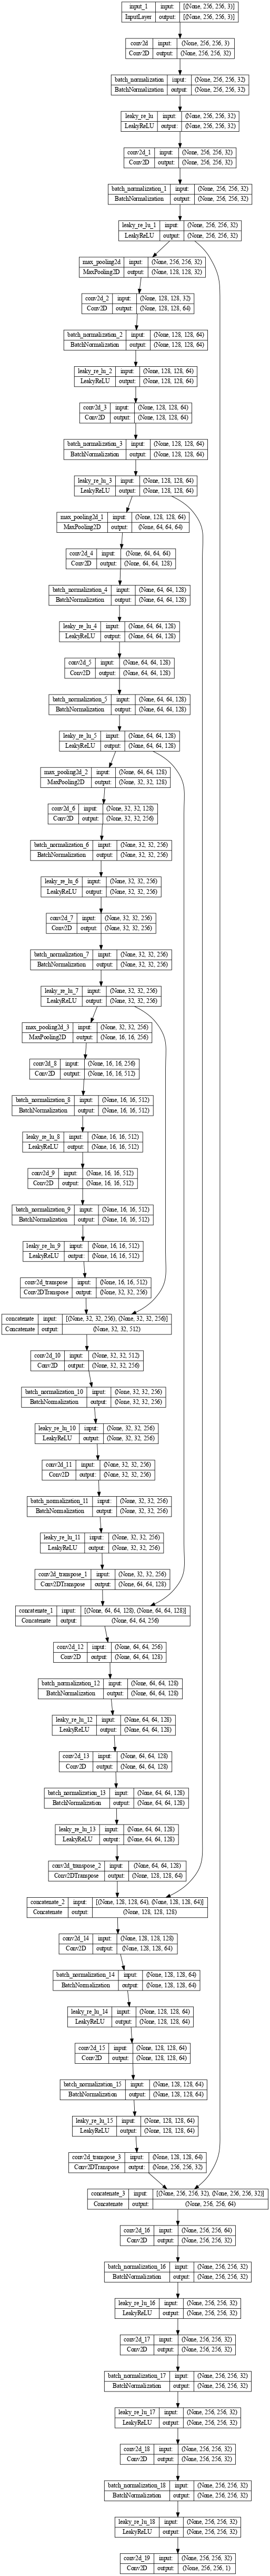

In [19]:
# Plotting  model---------------------------
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=60
)

In [20]:
#Summary of model------------------
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 16, 16, 512)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 512)  2359296     ['leaky_re_lu_8[0][0]']          
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 16, 16, 512)  2048       ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_9 (LeakyReLU)      (None, 16, 16, 512)  0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_tr

 batch_normalization_16 (BatchN  (None, 256, 256, 32  128        ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 leaky_re_lu_16 (LeakyReLU)     (None, 256, 256, 32  0           ['batch_normalization_16[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 256, 256, 32  9216        ['leaky_re_lu_16[0][0]']         
                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 256, 256, 32  128        ['conv2d_17[0][0]']              
 ormalizat

In [21]:
#compile model--------------------
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss=[jaccard_loss],metrics=[jaccard_coef])


In [ ]:
#Train model---------------------------
nbatch_size=8
nepochs=20
history = model.fit(X_train,Y_train,batch_size=nbatch_size,epochs=nepochs,validation_split=0.2)


2023-03-06 17:30:05.166238: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 574095360 exceeds 10% of free system memory.
2023-03-06 17:30:06.361430: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 191365120 exceeds 10% of free system memory.


Epoch 1/20


2023-03-06 17:30:17.607674: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.
2023-03-06 17:30:18.462810: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.
2023-03-06 17:30:18.494921: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.


47/92 [==============>...............] - ETA: 7:47 - loss: -0.2751 - jaccard_coef: 0.2751

In [ ]:
# Plotting loss change over epochs---------------
nrange=nepochs
x = [i for i in range(nrange)]
plt.plot(x,history.history['loss'])
plt.title('change in loss over epochs')
plt.legend(['jaccard_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
#plt.axis('off')
plt.grid(None)
plt.show()
plt.tight_layout()



In [ ]:
# Plotting IoU change over epochs---------------------
x = [i for i in range(nrange)]
plt.plot(x,history.history['jaccard_coef'])
plt.title('change in jaccard coefitient over epochs')
plt.legend(['jaccard coefitient'])
plt.xlabel('epochs')
plt.ylabel('jaccard coefitient')
plt.grid(None)
plt.show()
plt.tight_layout()


In [ ]:
# Creating predictions on our test set-----------------
predictions = model.predict(X_test)



In [ ]:
# create predictes mask--------------

def create_mask(predictions,input_shape=(w,h,1)):
    mask = np.zeros(input_shape)
    mask[predictions>0.5] = 1
    return mask



In [ ]:
# Ploting results for one image

def plot_results_for_one_sample(sample_index):
    
    mask = create_mask(predictions[sample_index])
    
    fig = plt.figure(figsize=(20,20))
    fig.add_subplot(1,4,1)
    plt.title('Input image')
    plt.imshow(X_test[sample_index])
    plt.axis('off')
    plt.grid(None)
    
    fig.add_subplot(1,4,2)
    plt.title('Real mask')
    plt.imshow(Y_test[sample_index])
    plt.axis('off')
    plt.grid(None)
    
    fig.add_subplot(1,4,3)
    plt.title('Predicted mask')  
    plt.imshow(mask)
    plt.axis('off')
    plt.grid(None)
    
    fig.add_subplot(1,4,4)
    plt.title("Mask + image")
    plt.imshow(X_test[sample_index]*mask)
    plt.grid(None)
    plt.axis('off')  
    fig.tight_layout()
    


In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(0)



In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(1)



In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(2)


In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(4)


In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(5)
